# Stacked Convolutional Autoencoder
Stacked Convolutional Autoencoder to extract meaningful representations from the Fashion-MNIST Dataset and analyze the information captured by these representations.

In [ ]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


In [ ]:
# Downloading the Fashion-MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.41MB/s]


Implement a Stacked Convolutional Autoencoder based on the specifications provided below. For each layer in the encoder, include comments that clearly indicate the dimensions of the feature maps after that layer.

Additionally, implement the corresponding decoder architecture that mirrors the encoder. For each decoder, include comments specifying the dimensions of the reconstructed feature maps.

This will help in verifying the symmetry and ensuring correct reconstruction of the input.

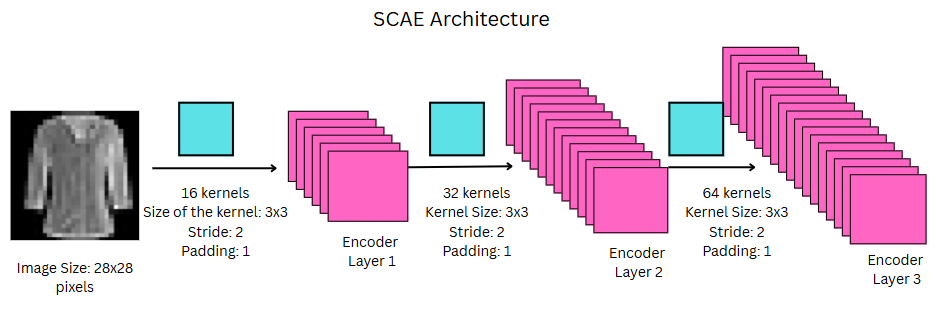

In [ ]:
'''
class ConvAutoencoderLayer(nn.Module):
    def __init__(self, encoder, decoder):
        """Define your autoencoder layer. Note: Remember the difference between a Stacked Autoencoder and a Deep CNN."""
        super(ConvAutoencoderLayer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        """Perform a forward pass."""
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
'''

In [ ]:
"""
def train_autoencoder():

    You are free to have your own function name. Write a trainer loop for the model. It must follow the below pattern
    1. Pass the input to the model and perform forward propagation
    2. Obtain losses
    3. Backpropagate to find the gradients

    Make sure to print the loss at each epoch.


def train_autoencoder(num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data, _ in train_loader:
            img = data.to(device)
            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")
"""

In [ ]:
'''
class StackedConvAutoencoder(nn.Module):
    def __init__(self, encoders, decoders):
      "Define the final stacked autoencoder"

    def forward(self, x):
      "Give the forward pass"

class StackedConvAutoencoder(nn.Module):
    def __init__(self, layers):
        super(StackedConvAutoencoder, self).__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        encodings = []
        for layer in self.layers:
            x, _ = layer(x)
            encodings.append(x)
        for layer in reversed(self.layers):
            _, x = layer(x)
        return x
'''

In [ ]:
#Imports
# reference: https://towardsdatascience.com/stacked-autoencoders-f0a4391ae282/
# https://youtu.be/345wRyqKkQ0?si=ah1R9iNv2beIn-nl
# https://github.com/ShayanPersonal/stacked-autoencoder-pytorch/blob/master/run.py

import numpy as np
from sklearn.manifold import TSNE
import random

class StackedConvAutoencoder(nn.Module):
    def __init__(self):
        super(StackedConvAutoencoder, self).__init__()

        # Encoder Architecture based on the provided image
        self.encoder = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # The decoder needs to upsample and reduce the number of channels
        # to reconstruct the original 28x28 image with 1 channel.
        # We need to calculate the dimensions after the encoder layers to properly
        # define the ConvTranspose2d layers.
        # Input (28x28x1) -> Conv1 (16 kernels, 3x3, stride 2, padding 1)
        # Output size after Conv1: (28 - 3 + 2*1)/2 + 1 = 14.5 -> floor(14) (if output_padding is not handled)
        # For stride 2, output size is ceil(input_size / stride) or floor(input_size / stride)
        # output_height = (input_height - kernel_height + 2 * padding_height) / stride_height + 1
        # Layer 1: (28 - 3 + 2*1)/2 + 1 = 14.5. The Conv2d with stride 2 and padding 1 effectively halves the dimension.
        # (28x28) -> Conv2d(1,16,k3,s2,p1) -> (14x14x16)
        # (14x14x16) -> Conv2d(16,32,k3,s2,p1) -> (7x7x32)
        # (7x7x32) -> Conv2d(32,64,k3,s2,p1) -> (4x4x64) -- This is the latent space size.

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # kernel_size=4, stride=2 to correctly upsample from 7x7 to 14x14 not kernel_size = 3!!!!!!
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # kernel_size=4, stride=2 to correctly upsample from 14x14 to 28x28
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1), # kernel_size = 4 does not necessarily mirror encoder size 3.
            nn.Sigmoid()  # Sigmoid to scale output pixels between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [ ]:

def train_autoencoder(model, train_loader, epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print("Starting Training...")
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            images, _ = data
            images = images.to(device)

            # 1. Forward propagation
            outputs = model(images)

            # 2. Obtain loss
            loss = criterion(outputs, images)

            # 3. Backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    print("Training Finished.")



In [ ]:
# 1. define the training and testing dataloaders
# 3. Set up hyper-params
BATCH_SIZE = 10
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Define the model
model = StackedConvAutoencoder().to(device)

# 4. Train the model
train_autoencoder(model=model, train_loader=train_loader, epochs=NUM_EPOCHS, lr=LEARNING_RATE)


Starting Training...
Epoch [1/10], Loss: 0.0085
Epoch [2/10], Loss: 0.0031
Epoch [3/10], Loss: 0.0021
Epoch [4/10], Loss: 0.0016
Epoch [5/10], Loss: 0.0014
Epoch [6/10], Loss: 0.0012
Epoch [7/10], Loss: 0.0011
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0009
Training Finished.



Visualizing Original vs. Reconstructed Images...


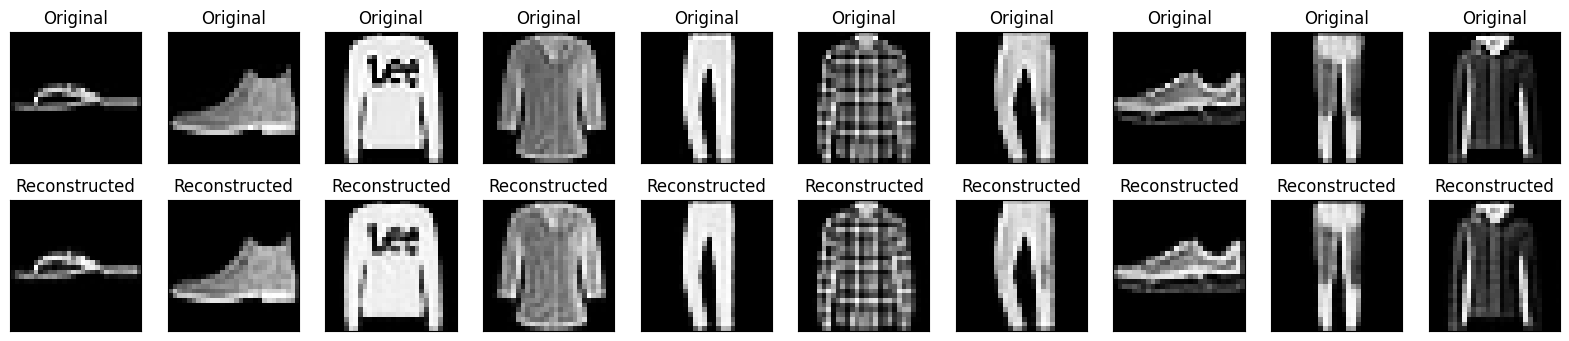

In [ ]:


# 5. Plot
print("\nVisualizing Original vs. Reconstructed Images...")
model.eval() # Set model to evaluation mode so that no changes are made
with torch.no_grad():

    dataiter = iter(test_loader)
    images, _ = next(dataiter)


    indices = random.sample(range(BATCH_SIZE), 10)
    sample_images = images[indices].to(device)


    reconstructed = model(sample_images)

    # Move images to CPU for plotting
    sample_images = sample_images.cpu()
    reconstructed = reconstructed.cpu()

    plt.figure(figsize=(20, 4))
    for i in range(10):
        # Original images
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


In [ ]:

# 6. Save the model
MODEL_PATH = 'stacked_conv_autoencoder_fashion_mnist.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to stacked_conv_autoencoder_fashion_mnist.pth



Extracting and visualizing embeddings using t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


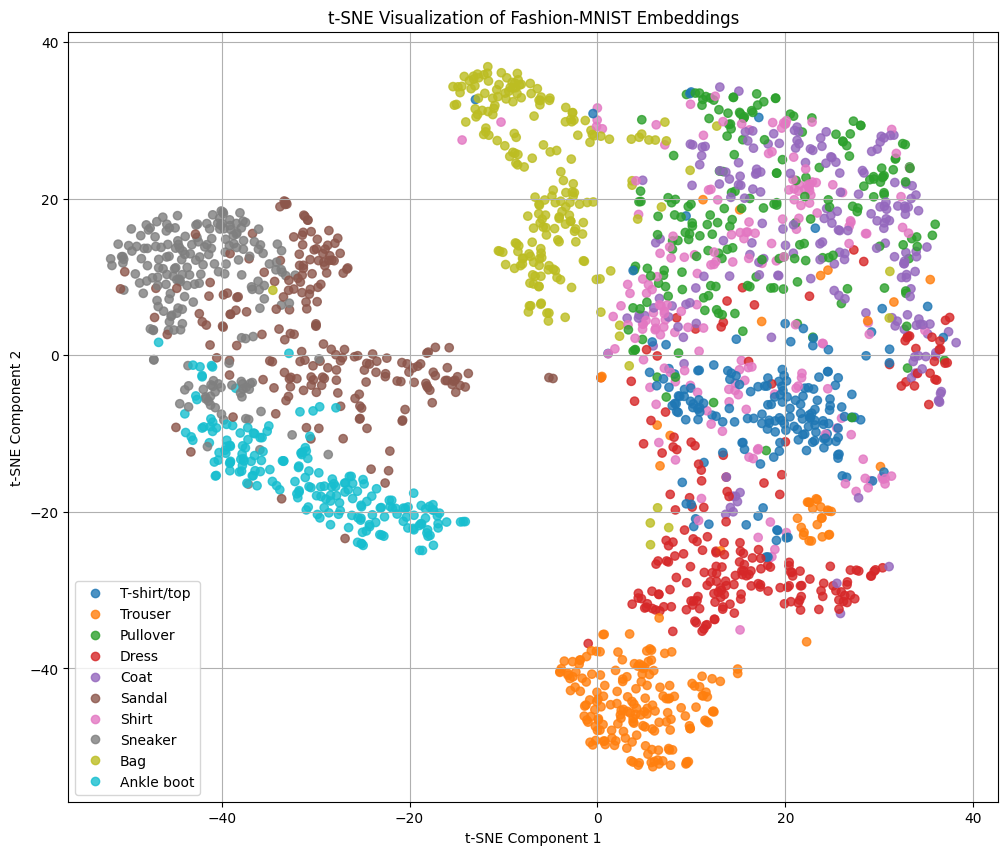

In [ ]:

# 7. Extract the embeddings
print("\nExtracting and visualizing embeddings using t-SNE...")

# Create a subset of 2000 images from the test set
subset_indices = random.sample(range(len(test_dataset)), 2000)
embedding_subset = Subset(test_dataset, subset_indices)
embedding_loader = DataLoader(embedding_subset, batch_size=BATCH_SIZE, shuffle=False)


classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

embeddings = []
labels = []
model.eval()
with torch.no_grad():
    for images_batch, labels_batch in embedding_loader:
        images_batch = images_batch.to(device)
        # Pass through the encoder only
        encoded_output = model.encoder(images_batch)
        # Flatten the embeddings
        encoded_output = encoded_output.view(encoded_output.size(0), -1)
        embeddings.append(encoded_output.cpu().numpy())
        labels.append(labels_batch.numpy())

embeddings = np.concatenate(embeddings, axis=0) # The final shape will be [2000, 3136]
labels = np.concatenate(labels, axis=0) # NumPy array of shape [2000]

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# n_components=2: Specifies that the high-dimensional embeddings should be reduced to 2 dimensions.
# rs = seed for reproducability, any number can be used, idk y 42 is very common no matter where u go lol
# perplexity = similar to nearest neighbours, value can be useful to help with overfitting or underfitting
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize the t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.title('t-SNE Visualization of Fashion-MNIST Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.grid(True)
plt.show()